# Labor Force Statistics from CPS Microdata

Brian Dew, @bd_econ, brian.w.dew@gmail.com

In [1]:
import wquantiles
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

dt = cps_date()
def to_date(ym):
    return pd.to_datetime(f'{ym[0]}-{ym[1]}-01')

### Overview data and text

In [2]:
yr_wt = {y: 'PWSSWGT' if y > 1993 else 'BASICWGT' for y in range(1989, 2022)}

cols = ['LFS', 'AGE', 'MONTH', 'YEAR', 'FEMALE']

df = pd.concat([(pd.read_feather(cps_dir / f'cps{y}.ft', columns=cols + [w])
                   .rename({w: 'WGT'}, axis=1)) 
                for y, w in yr_wt.items()], sort=False)
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=1))
data = df.groupby(['DATE', 'LFS']).WGT.sum().unstack().rename({'nan': 'Children'}, axis=1) / 1000000
data.to_csv(data_dir/ 'cps_lfs.csv', index_label='date')

datelt = dtxt(data.index[-1])['mon1']
dateltsh = dtxt(data.index[-1])['mon2']
dateyr = dtxt(data.index[-13])['mon1']
dateprepan = dtxt(data.index[-25])['mon1']
dateyrsh = dtxt(data.index[-13])['mon2']
datepr = f"{dateyr} to {datelt}"

write_txt(text_dir / 'cps_lfs_date.txt', datelt)
write_txt(text_dir / 'cps_lfs_datesh.txt', dateltsh)
write_txt(text_dir / 'cps_lfs_dateyr.txt', dateyr)
write_txt(text_dir / 'cps_lfs_dateprepan.txt', dateprepan)
write_txt(text_dir / 'cps_lfs_dateyrsh.txt', dateyrsh)
write_txt(text_dir / 'cps_lfs_datepr.txt', datepr)

epop = data["Employed"].iloc[-1] / data.iloc[-1].sum() * 100

In [3]:
text = (f'As of {datelt}, {data["Employed"].iloc[-1]:.1f} million '+
        'people are employed (including self-employment). ')

write_txt(text_dir / 'cps_lfs0.txt', text)

text = ('The number of people who are considered employed divided by the total '+
        'population is the employment rate or employment-to-population ratio, '+
        f'which is {epop:.1f} percent as of {datelt}.')

write_txt(text_dir / 'cps_lfs.txt', text)

unemp = (data["Unemployed"].iloc[-1] / (data["Unemployed"].iloc[-1] + data["Employed"].iloc[-1])) * 100
lfpr = (data["Unemployed"].iloc[-1] + data["Employed"].iloc[-1]) / data.iloc[-1].sum() * 100

text = (f'As of {datelt}, there are {data["Unemployed"].iloc[-1]:.1f} million '+
        'unemployed people. The combined group of employed and unemployed people '+
        'is the labor force. The number of unemployed people divided by the number '+
        f'of people in the labor force is the unemployment rate, currently {unemp:.1f} percent. '+
        'The number of people in the labor force divided by the total population is the '+
        f'labor force participation rate, currently {lfpr:.1f} percent.')

write_txt(text_dir / 'cps_lfs2.txt', text)
    
cols2 = cols + ['NILFREASON', 'PWSSWGT']

datalt = cps_1mo(cps_dir, cps_date(), cols2)

student = (datalt.query('NILFREASON == "School"').PWSSWGT.sum() / 1000000)
care = (datalt.query('NILFREASON == "Family"').PWSSWGT.sum() / 1000000)
disill = (datalt.query('NILFREASON == "Disabled/Ill"').PWSSWGT.sum() / 1000000)
disc = (datalt.query('NILFREASON == "Discouraged"').PWSSWGT.sum() / 1000000)
ret = (datalt.query('NILFREASON == "Retired"').PWSSWGT.sum() / 1000000)

nilfpop = data[['NILF', 'Children']].iloc[-1].sum()
text = ('Non-participants usually comprise about half of the population, and '+
        f'total {nilfpop:.1f} million in {datelt}. The category includes '+
        f'children ({data["Children"].iloc[-1]:.1f} million), students '+
        f'({student:.1f} million), unpaid caregivers ({care:.1f} million), those '+
        f'unable to work due to disability or illness ({disill:.1f} million), '+
        f'those who want a job but have given up looking ({disc:.1f} '+
        f'million), and retirees and the elderly ({ret:.1f} million).')

write_txt(text_dir / 'cps_lfs3.txt', text)
    
data['Total'] = data[['Employed', 'Unemployed', 'NILF']].sum(axis=1)
result = data.drop('Children', axis=1).resample('QS').mean()

growth_contrib_ann(result, 'Total').dropna().to_csv(data_dir / 'cps_lfs2.csv', index_label='date')

print(text)

Non-participants usually comprise about half of the population, and total 164.2 million in May 2021. The category includes children (59.9 million), students (17.3 million), unpaid caregivers (13.5 million), those unable to work due to disability or illness (14.1 million), those who want a job but have given up looking (7.4 million), and retirees and the elderly (50.4 million).


### LFS Table

In [4]:
cols = ['LFS', 'PWSSWGT', 'AGE', 'MONTH', 'YEAR', 'MJH',
        'FEMALE', 'NILFREASON', 'UNEMPTYPE', 'PTECON', 'WORKFT']

df = cps_1mo(cps_dir, cps_date(), cols).query('AGE >= 15')
df2 = cps_1mo(cps_dir, cps_date() - pd.DateOffset(years=1), cols).query('AGE >= 15')

age_groups = [(15, 30), (30, 60), (60, 86)]
sex = [0, 1]
d = {'Population': {'query': 'PWSSWGT > 0'}, 
     '\hspace{2mm}Employed': {'query': 'LFS == "Employed"'}, 
     '\hspace{4mm}Multiple jobs': {'query': 'MJH == 1'},     
     '\hspace{4mm}Full-time': {'query': 'WORKFT == 1'},  
     '\hspace{4mm}Part-time': {'query': 'WORKFT == 0'}, 
     '\hspace{6mm}Economic reasons': {'query': 'PTECON == 1'},
     '\hspace{2mm}Unemployed': {'query': 'LFS == "Unemployed"'}, 
     '\hspace{2mm}Not in Labor Force': {'query': 'LFS == "NILF"'}, 
     '\hspace{4mm}Discouraged': {'query': 'NILFREASON == "Discouraged"'}, 
     '\hspace{4mm}Disabled/Ill': {'query': 'NILFREASON == "Disabled/Ill"'}, 
     '\hspace{4mm}Family/Care': {'query': 'NILFREASON == "Family"'}, 
     '\hspace{4mm}School': {'query': 'NILFREASON == "School"'}, 
     '\hspace{4mm}Retirement': {'query': 'NILFREASON == "Retired"'}}

d2 = {k: {} for k, v in d.items()}

lf_groups = list(zip(d.keys(), [d[i]['query'] for i in d.keys()])) 

for name, query in lf_groups:
    totval = df.query(query).PWSSWGT.sum()/1000
    d[name]['Total, 15+'] = f'{totval:,.0f}'
    chval = totval - df2.query(query).PWSSWGT.sum()/1000
    d2[name]['Total, 15+'] = f'{chval:,.0f}'

for sex, (agemin, agemax) in itertools.product(sex, age_groups):
    data = df.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    data2 = df2.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    group = f'{["Women" if sex==1 else "Men"][0]}, {agemin}--{agemax-1}'.replace('--85', '+')
    for name, query in lf_groups:
        tmp = data.query(query).PWSSWGT.sum()/1000
        tmp2 = data2.query(query).PWSSWGT.sum()/1000
        d[name][group] = f'{tmp:,.0f}'
        d2[name][group] = f'{tmp - tmp2:,.0f}'
        
(pd.DataFrame(d).T.drop('query', axis=1).to_csv(data_dir / 'lfs_table1.tex', 
    sep='&', line_terminator='\\\ ', quotechar=' '))
pd.DataFrame(d2).T.to_csv(data_dir / 'lfs_table2.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

### Employment rates by age, gender, education

In [5]:
cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'AGE', 'EDUC', 'FEMALE']
#df1 = pd.read_feather(cps_dir / 'cps2000.ft', columns=cols).query('PWSSWGT > 0')
df1 = cps_3mo(cps_dir, cps_date() - pd.DateOffset(months=24), cols)
df2 = cps_3mo(cps_dir, cps_date(), cols)

ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
educ = [['LTHS', 'HS'], ['SC'], ['COLL', 'ADV'], ['LTHS', 'HS', 'SC', 'COLL', 'ADV']]
sex = [0, 1]

results = pd.DataFrame()
for a, e, s in itertools.product(ages, educ, sex):
    row_name = f'{a[0]}-{a[1]}'
    col_name = f'{" or ".join(e)} {["Female" if s == 1 else "Male"][0]}'
    for yr, df in [('Year Ago', df1), ('Latest', df2)]:
        data = df.query('@a[0] <= AGE <= @a[1] and EDUC in @e and FEMALE == @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, f'{yr} {col_name}'] = (i.Employed / i.sum()) * 100
        
results.iloc[1:, :-4].to_csv(data_dir / 'empgroups.csv', index_label='name')
results.iloc[:, -4:].to_csv(data_dir / 'empgroups2.csv', index_label='name')

### Union Membership

In [6]:
union_membership_rate = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT'])
union_coverage_rate = lambda x: np.average(x['UNION'], weights=x['PWORWGT'])

unmem, uncov = pd.Series(dtype='float64'), pd.Series(dtype='float64')

untot, nuntot = pd.Series(dtype='float64'), pd.Series(dtype='float64')

columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNION', 'UNIONMEM']
for year in range(1989, 2022):
    df = (pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
        .query('LFS == "Employed" and UNION in [0, 1]'))
    data1 = df.groupby(['YEAR', 'MONTH']).apply(union_membership_rate)
    data1.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data1.index]
    unmem = unmem.append(data1)
    data2 = df.groupby(['YEAR', 'MONTH']).apply(union_coverage_rate)
    data2.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data2.index]
    uncov = uncov.append(data2)
    df2 = df.query('UNIONMEM == 1')   
    data3 = df2.groupby(['YEAR', 'MONTH']).PWORWGT.sum()
    data3.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data3.index]
    untot = untot.append(data3)
    df3 = df.query('UNIONMEM == 0')
    data4 = df3.groupby(['YEAR', 'MONTH']).PWORWGT.sum()
    data4.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data4.index]
    nuntot = nuntot.append(data4)    
    
data = pd.DataFrame({'Membership': unmem, 'Coverage': uncov})
levels = pd.DataFrame({'Union': untot, 'Nonunion': nuntot})
data['Diff'] = data['Coverage'] - data['Membership']
final = (data.rolling(12).mean().dropna() * 100)
final.to_csv(data_dir / 'union.csv', index_label='date', float_format='%g')
final2 = (levels.rolling(12).mean().dropna()) / 1000000

ltdate = final.index[-1].strftime('%B %Y')
prevdate = final.index[-13].strftime('%B %Y')
prev2date = final.index[-25].strftime('%B %Y')

ltval = final['Membership'].iloc[-1]
prevval = final['Membership'].iloc[-13]
prev2val = final['Membership'].iloc[-25]

totvallt = final2['Union'].iloc[-1]
totnvallt = final2['Nonunion'].iloc[-1]

chlt = final2['Union'].diff(12).iloc[-1] * 1000000
chpr = final2['Union'].diff(12).iloc[-13] * 1000000

chnlt = final2['Nonunion'].diff(12).iloc[-1] * 1000000
chnpr = final2['Nonunion'].diff(12).iloc[-13] * 1000000

if chlt > 10:
    chlt_txt = f'increased by {round(chlt, -3):,.0f}'
elif chlt <= -10:
    chlt_txt = f'decreased by {abs(round(chlt, -3)):,.0f}'
else:
    chlt_txt = 'were virtually unchanged'
    
if chnlt > 10:
    chnlt_txt = f'increased by {round(chnlt, -3):,.0f}'
elif chnlt <= -10:
    chnlt_txt = f'decreased by {abs(round(chnlt, -3)):,.0f}'
else:
    chnlt_txt = 'were virtually unchanged'
    
text = (f'Over the 12 months ending {ltdate}, the share of jobs held '+
        f'by union and employee association members averaged {ltval:.1f} percent. '+
        f'In levels, there were {totvallt:.1f} million union jobs, and '+
        f'{totnvallt:.1f} million nonunion jobs, on average over the period. '+
        f'This union membership rate averaged {prevval:.1f} percent during the 12 '+
        f'months ending {prevdate}, and {prev2val:.1f} percent during the 12 '+
        f'months ending {prev2date}. Union jobs {chlt_txt} '+
        f'from {prevdate} to {ltdate}, while nonunion jobs {chnlt_txt}.')
write_txt(text_dir / 'union.txt', text)
print(text)

Over the 12 months ending May 2021, the share of jobs held by union and employee association members averaged 10.6 percent. In levels, there were 14.1 million union jobs, and 118.9 million nonunion jobs, on average over the period. This union membership rate averaged 10.5 percent during the 12 months ending May 2020, and 10.4 percent during the 12 months ending May 2019. Union jobs decreased by 428,000 from May 2020 to May 2021, while nonunion jobs decreased by 5,046,000.


In [7]:
union_membership_rate = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT']) * 100
columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNIONMEM', 'INDGRP']

df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
                  .query('PWORWGT > 0 and UNIONMEM == UNIONMEM')
      for year in range(1989, 2022)])

df.INDGRP.cat = df.INDGRP.cat.remove_unused_categories()

data = df.groupby(['YEAR', 'MONTH', 'INDGRP']).apply(union_membership_rate).unstack()
data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data.index]
data.index.name = 'date'
data.columns.name = None
prev12 = data.iloc[-12:].mean()
lval = data.iloc[-1]
minval = data.min()
maxval = data.max()
width = maxval - minval
final = pd.concat([lval, prev12, minval, maxval, width], axis=1)
final.columns = ['latest', 'prev12', 'min', 'max', 'width']
final.index.name = 'name'
final = final[['min', 'width', 'latest']].sort_values('latest', ascending=False)
final['y'] = [0.13, -0.87, -1.87, -2.87, -3.87, -4.87, -5.87]
final.to_csv(data_dir / 'union_ind.csv', sep=';')

dec = (maxval - lval).sort_values()
dec1 = dec.index[-1]
decval1 = dec[-1]
decmaxdt = dtxt(data[dec1].idxmax())['mon1']
decmaxval = data[dec1].max()
decgrp = dec1.lower()
lowgroupmaxdt = dtxt(data[final.index[-1]].idxmax())['mon1']
lowgrp = final.index[-1].lower()


text = (f'{final.index[0]} has the highest union membership rate, '+
        f'at {final.latest.iloc[0]:.1f} percent as of {ltdate}, followed by '+
        f'{final.index[1].lower()} with {final.latest.iloc[1]:.1f} percent, '+
        f'and {final.index[2].lower()} with {final.latest.iloc[2]:.1f} percent. '+
        f'The {decgrp} industry '+
        'experienced the largest overall percentage point decrease '+
        'in union membership rates over the past 30 years, and is '+
        f'currently {decval1:.1f} percentage points below its {decmaxdt} '+
        f'rate of {decmaxval:.1f} percent. ')
txt2 = ('The lowest union membership rate '+
        f'is in {lowgrp} ({final.latest.iloc[-1]:.1f} percent). '+
        f'The union membership rate of the industry was {data[final.index[-1]].max():.1f} '+
        f'percent at its 30-year peak in {lowgroupmaxdt}. ')

mfglt = data['Manufacturing'].iloc[-1]
mfgpr = data['Manufacturing'].iloc[-13]
prdt = dtxt(data.index[-13])['mon1']
mfgpr2 = data['Manufacturing'].iloc[-25]
prdt2 = dtxt(data.index[-25])['mon1']

txt3 = (f'The manufacturing industry union membership rate was {mfglt:.1f} percent in {ltdate}, '+
        f'{mfgpr:.1f} percent in {prdt}, and {mfgpr2:.1f} percent in {prdt2}.')

if lowgrp == decgrp:
    text = text + txt3
else:
    text = text + txt2

write_txt(text_dir / 'union_ind.txt', text)
print(text)

Public administration has the highest union membership rate, at 27.9 percent as of May 2021, followed by education and health with 16.5 percent, and construction and mining with 13.4 percent. The manufacturing industry experienced the largest overall percentage point decrease in union membership rates over the past 30 years, and is currently 14.9 percentage points below its February 1989 rate of 23.5 percent. The lowest union membership rate is in finance and business services (3.4 percent). The union membership rate of the industry was 7.2 percent at its 30-year peak in March 1992. 


### Matching YY -- Disability to Work Flows

Over the year ending May 2021, 7.4 percent of persons age 25--54 who were out of the labor force due to disability or illness in the prior year are now employed (see {\color{blue}\textbf{---}}). This one-year rate of job-finding has increased substantially from its 2010--2013 average of 5.8 percent


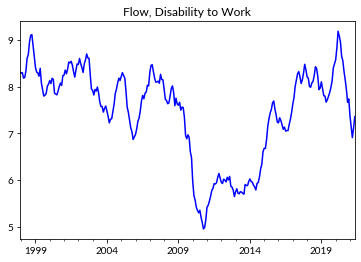

In [8]:
cols = ['CPSID', 'AGE', 'FEMALE', 'WBHAO', 'NILFREASON', 
        'LFS', 'MIS', 'BASICWGT', 'LINENO']

emp = lambda x: np.where(x.LFS_y == 'Employed', 1, 0)

dates = pd.date_range('1997-01-01', cps_date(), freq='MS')

d = {}

for dt in dates:
    df1 = (cps_1mo(cps_dir, dt - pd.DateOffset(years=1), cols)
           .query('NILFREASON == "Disabled/Ill"'))
    df2 = cps_1mo(cps_dir, dt, cols)
    data = (pd.merge(df1, df2, on=['CPSID', 'LINENO', 'FEMALE', 'WBHAO'])
              .query('25 <= AGE_y <= 54'))
    data = (data.loc[(data.AGE_x <= data.AGE_y) & 
                     (data.AGE_y - 2 <= data.AGE_x)]).assign(EMP = emp)

    d[dt] = np.average(data.EMP, weights=data.BASICWGT_y) * 100
    
df = pd.Series(d).rolling(12).mean().dropna().rename('Share')

df.to_csv(data_dir / 'disflow.csv', index_label='date', header=True)
write_txt(text_dir/ 'disflow_node.txt', end_node3(df, 'blue'))

latest = df.iloc[-1]
valavg = df.loc['2010-12-01':'2013-12-01'].mean()
ltdate = dtxt(df.index[-1])['mon1']

text = (f'Over the year ending {ltdate}, {latest:.1f} percent of '+
        'persons age 25--54 who were out of the labor force due to disability or illness '+
        'in the prior year are now employed (see {\color{blue}\\textbf{---}}). '+
        'This one-year rate of job-finding has increased '+
        f'substantially from its 2010--2013 average of {valavg:.1f} percent')

write_txt(text_dir / 'disflow.txt', text)

print(text)
df.plot(color='blue', title='Flow, Disability to Work');

### CPS Labor Force Nonparticipation by Reason

Replication using python of a very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

In [9]:
os.chdir(cps_dir)

years = range(2000, 2022)
ref_pd = (2001, 3)
ref_dt = to_date(ref_pd)
ages = '18 <= AGE <= 64'
wgt = 'BASICWGT'
cat = 'NILFREASON'
dates = ['YEAR', 'MONTH']
dems = ['FEMALE', 'AGE']
cols = dates + dems + [wgt, cat]
files = [f'cps{year}.ft' for year in years]

# CPS Data
df = pd.concat([pd.read_feather(file, columns=cols)
                  .query(ages) for file in files])

p = df.groupby(dates + dems)[wgt].sum().rename('ADJ')
sh = (p / p.groupby(dates).sum())
adj = (sh.loc[ref_pd] / sh).reset_index()
data = (pd.merge(df, adj)
          .assign(ADJWGT = lambda x: x.ADJ * x[wgt]))
data.NILFREASON.cat.rename_categories({'nan': 'LF'}, 
                                      inplace=True)

# Make Adjustments
c = data.groupby(dates + [cat]).ADJWGT.sum()
dem_res = (c / c.groupby(dates).sum()).unstack()
dem_res.columns = dem_res.columns.to_list()

c_nd = data.groupby(dates + [cat])[wgt].sum()
nd_res = (c_nd / c_nd.groupby(dates).sum()).unstack()

dem_res['Demographics'] = dem_res['LF'] - nd_res['LF']
dem_res.index = [to_date(ym) for ym in dem_res.index]

keep_cols = dem_res.columns.difference(['LF'])
result = (dem_res.rolling(12).mean().dropna()
                 .loc[ref_dt:, keep_cols] * 100)

final = result.iloc[0] - result

#### Export result

In [10]:
os.chdir('/home/brian/Documents/uschartbook/chartbook/')

final.to_csv('data/nilf.csv', index_label='date')

colors = {'Disabled/Ill': 'green!80!blue', 
          'Discouraged': 'blue', 
          'Family': 'red', 
          'Retired': 'orange', 
          'School': 'cyan', 
          'Demographics': 'violet!80!purple'}

adj = node_adjust(final, colors)

node_file = open('text/nilf_nodes.txt', 'w')
for series, color in colors.items():
    if series in adj.keys():
        offset = adj[series]
    else:
        offset = 0
    node_file.write(end_node3(final[series], color, percent=False))
node_file.close()

#### Text

In [11]:
ltdate = dtxt(cps_date())['mon1']

lt = final.iloc[-1]
tot = abs(lt.sum())
dem = abs(lt['Demographics'])
demc = colors['Demographics']
sch = abs(lt['School'])
schc = colors['School']
dis = abs(lt['Disabled/Ill'])
disc = colors['Disabled/Ill']
ret = abs(lt['Retired'])
retc = colors['Retired']

text = (f'From March 2001 to the latest available twelve months of data, '+''+
        f'ending {ltdate}, an additional {tot:.1f} percent of the age 18--64 '+
         'population left the labor force. Changes in the demographic '+
         'composition of the population affect the rate of participation. '+
         'For example, the larger-than-normal population '+
         'cohort born after World War II is reaching retirement age in '+
        f'this period. Changes in the age and sex distribution explain {dem:.1f} '+
         'percentage points of the cumulative decrease since March 2001 '+
        f'(see {{\color{{{demc}}}\\textbf{{---}}}}). \n\nAdditionally, '+ 
         'young people are staying in school longer, on average, '+
        f'reducing the age 18--64 labor force by {sch:.1f} percent '+
        f'(see {{\color{{{schc}}}\\textbf{{---}}}}). '+
         'Disability and illness reduce the labor force by '+
        f'another {dis:.1f} percent '+
        f'(see {{\color{{{disc}}}\\textbf{{---}}}}). Less retirement among those age '+
        f'18--64 increases the labor force by {ret:.1f} percent, over '+
        f'the period (see {{\color{{{retc}}}\\textbf{{---}}}}).')

write_txt('text/nilf_01.txt', text)
print(text)

From March 2001 to the latest available twelve months of data, ending May 2021, an additional 3.8 percent of the age 18--64 population left the labor force. Changes in the demographic composition of the population affect the rate of participation. For example, the larger-than-normal population cohort born after World War II is reaching retirement age in this period. Changes in the age and sex distribution explain 1.1 percentage points of the cumulative decrease since March 2001 (see {\color{violet!80!purple}\textbf{---}}). 

Additionally, young people are staying in school longer, on average, reducing the age 18--64 labor force by 1.6 percent (see {\color{cyan}\textbf{---}}). Disability and illness reduce the labor force by another 0.5 percent (see {\color{green!80!blue}\textbf{---}}). Less retirement among those age 18--64 increases the labor force by 0.7 percent, over the period (see {\color{orange}\textbf{---}}).


#### Bar Chart

In [12]:
os.chdir(cps_dir)

result, share = pd.DataFrame(), pd.DataFrame()

dts = [cps_date(), cps_date() - pd.DateOffset(years=1)]

for date in dts:
    month =  date.month
    year = date.year
    data = (pd.read_feather(f'cps{year}.ft', columns=cols)
              .query('YEAR == @year and MONTH == @month'))
    
    dt = dtxt(date)['mon1']

    result[dt] = data.groupby('NILFREASON').BASICWGT.sum()
    share[dt] = result[dt] / result[dt].sum() * 100
    
os.chdir(cb_dir)

mo1 = dtxt(dts[0])['mon1']
mo2 = dtxt(dts[1])['mon1']

(share.drop('nan').round(1).sort_values(mo1, ascending=False)
       .to_csv(data_dir / 'nilf_comp.csv', index_label='name'))

write_txt(text_dir / 'nilf_mo1.txt', mo1)
write_txt(text_dir / 'nilf_mo2.txt', mo2)

pct = share[mo1]
pctpr = share[mo2]
lev = result[mo1] / 1_000_000

totlev = lev.drop('nan').sum()
totpct = pct.drop('nan').sum()
totpctpr = pctpr.drop('nan').sum()
retpct = pct['Retired']
dislev = lev['Disabled/Ill']
dispct = pct['Disabled/Ill']
schpct = pct['School']
carepct = pct['Family']

text = ('These labor force non-participants, which do not include '+
        f'those under the age of 15, total {totlev:.1f} million '+
        f'in {mo1}, or {totpct:.1f} percent of the age 15 or older '+
        f'population, compared to {totpctpr:.1f} percent in {mo2}. '+
         'Slightly less than half of non-participants, and '+
        f'{retpct:.1f} percent of population, are retirees in {mo1} '+
        '(see\cbox{green!80!blue!75!black}). A total of '+
        f'{dislev:.1f} million people, or {dispct:.1f} percent of the age '+
         '15 or older population, are out of the labor force due to disability '+
        f'or illness; {schpct:.1f} percent were out of the labor force for '+
        f'school, and {carepct:.1f} percent for family or caregiving reasons.')
write_txt(text_dir / 'nilfbasic.txt', text)
print(text)

These labor force non-participants, which do not include those under the age of 15, total 100.6 million in May 2021, or 38.5 percent of the age 15 or older population, compared to 39.3 percent in May 2020. Slightly less than half of non-participants, and 19.4 percent of population, are retirees in May 2021 (see\cbox{green!80!blue!75!black}). A total of 14.1 million people, or 5.4 percent of the age 15 or older population, are out of the labor force due to disability or illness; 5.2 percent were out of the labor force for school, and 5.1 percent for family or caregiving reasons.


### Occupations

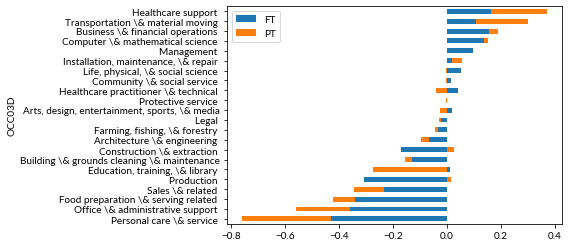

In [13]:
occs = {1   :  'Management occupations',
        2   :  'Business and financial operations occupations',
        3   :  'Computer and mathematical science occupations',
        4   :  'Architecture and engineering occupations',
        5   :  'Life, physical, and social science occupations',
        6   :  'Community and social service occupations',
        7   :  'Legal occupations',
        8   :  'Education, training, and library occupations',
        9   :  'Arts, design, entertainment, sports, and media',
        10  :  'Healthcare practitioner and technical occupations',
        11  :  'Healthcare support occupations',
        12  :  'Protective service occupations',
        13  :  'Food preparation and serving related occupations',
        14  :  'Building and grounds cleaning and maintenance',
        15  :  'Personal care and service occupations',
        16  :  'Sales and related occupations',
        17  :  'Office and administrative support occupations',
        18  :  'Farming, fishing, and forestry occupations',
        19  :  'Construction and extraction occupations',
        20  :  'Installation, maintenance, and repair occupations',
        21  :  'Production occupations',
        22  :  'Transportation and material moving occupations'}

cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'OCC03D', 'OCC203D', 'WORKFT', 'COW1', 'COW2']

df = cps_3mo(cps_dir, cps_date(), cols)
df2 = cps_3mo(cps_dir, cps_date() - pd.DateOffset(months=24), cols)

df['OCC03D'] = df['OCC03D'].map(occs)
df2['OCC03D'] = df2['OCC03D'].map(occs)

data = pd.DataFrame()

data['FT'] = (((df.query('WORKFT == 1').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum()) - 
              (df2.query('WORKFT == 1').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum())) * 100)
data['PT'] = (((df.query('WORKFT == 0').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum()) - 
              (df2.query('WORKFT == 0').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum())) * 100)
data['Total'] = data.sum(axis=1)

data.index = data.index.str.replace('occupations', '').str.replace('and', '\&')

data = data.sort_values('Total')
data.drop('Total', axis=1).to_csv(data_dir / 'occs.csv', sep=';', index_label='name', header=True)

data.drop('Total', axis=1).plot(kind='barh', stacked=True);

data1 = data.drop('Total', axis=1)

### Atlanta Fed WGT

In [14]:
cols = ['AGE', 'HRWAGE', 'ATLFLG', 'FEMALE', 'CPSID', 'WBHAO', 
        'LINENO', 'WKEARN']

filters = 'HRWAGE >= 2.13 and ATLFLG == 1'

dates = pd.date_range('1997-01-01', cps_date(), freq='MS')

d = {}
d2 = {}
d3 = {}

for dt in dates:
    df1 = cps_1mo(cps_dir, dt - pd.DateOffset(years=1), cols).query(filters)
    df2 = cps_1mo(cps_dir, dt, cols).query(filters)
    data = (pd.merge(df1, df2, on=['CPSID', 'LINENO', 'FEMALE', 'WBHAO']))
    data = (data.loc[(data.AGE_x <= data.AGE_y) & 
                     (data.AGE_y - 2 <= data.AGE_x)])
    wage_change_array = ((data['HRWAGE_y'] / data['HRWAGE_x']) - 1) * 100
    wkpy_change_array = ((data['WKEARN_y'] / data['WKEARN_x']) - 1) * 100
    d[dt] = wage_change_array.median()
    d3[dt] = wkpy_change_array.median()
    zwc = (len(wage_change_array[(wage_change_array >= -0.5) & 
                                 (wage_change_array <= 0.5)]) / len(wage_change_array)) * 100
    d2[dt] = zwc

result = pd.Series(d, name='bd_cps').to_frame()
result['3ma'] = result.rolling(3).mean()
result['wk'] = pd.Series(d3, name='wkpy').to_frame()
result['wk3ma'] = result['wk'].rolling(3).mean()
result['zwc'] = pd.Series(d2).rolling(3).mean()

result.to_csv(data_dir/ 'atl_wgt.csv', index_label='date')

ltdate = dtxt(result.index[-1])['mon1']
ltval = result['bd_cps'].iloc[-1]
lt3m = result['3ma'].iloc[-1]
yrdt = dtxt(result.index[-13])['mon1']
pr3m = result['3ma'].iloc[-13]

also = ''
if round(lt3m) == round(pr3m):
    also = 'also '

text = ('Replication of the wage growth tracker '+
        'using the bd CPS shows matched-observation hourly wage growth of '+
        f'{ltval:.1f} percent in {ltdate} '+
        '(see {\color{orange!60!white}\\textbf{---}}), and average wage '+
        f'growth of {lt3m:.1f} percent over the three months ending {ltdate} '+
        '(see {\color{blue!75!cyan}\\textbf{---}}). '+
        f'One year prior, in {yrdt}, three-month moving average '+
        f'wage growth was {also}{pr3m:.1f} percent.')
print(text)
write_txt(text_dir / 'atl_wgt.txt', text)

ltval = result['zwc'].iloc[-1]
prval = result['zwc'].iloc[-2]
prdate = dtxt(result.index[-2])['mon1']
yrval = result['zwc'].iloc[-13]

text = (f'In {ltdate}, {ltval:.1f} '+
        'percent of individuals had no hourly wage growth, compared to '+
        f'{prval:.1f} in {prdate} '+
        '(see {\color{red}\\textbf{---}}). One year prior, '+
        f'in {yrdt}, {yrval:.1f} '+
        'percent of individuals had no wage growth.')
print(text)
write_txt(text_dir / 'atl_zwc.txt', text)

Replication of the wage growth tracker using the bd CPS shows matched-observation hourly wage growth of 3.0 percent in May 2021 (see {\color{orange!60!white}\textbf{---}}), and average wage growth of 3.1 percent over the three months ending May 2021 (see {\color{blue!75!cyan}\textbf{---}}). One year prior, in May 2020, three-month moving average wage growth was 3.7 percent.
In May 2021, 14.5 percent of individuals had no hourly wage growth, compared to 13.9 in April 2021 (see {\color{red}\textbf{---}}). One year prior, in May 2020, 14.2 percent of individuals had no wage growth.


### Unemployment Rate for Smaller Groups

In [3]:
cols = ['YEAR', 'MONTH', 'WBHAOM', 'BASICWGT', 'LFS', 'AGE', 'FEMALE']
groups = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'More than one']

unrate = lambda x: np.average(x['UNEMP'], weights=x['BASICWGT']) * 100
unsh = lambda x: (x['UNEMP'] * x['BASICWGT']).sum()
unemp = lambda x: np.where(x['LFS'] == 'Unemployed', 1, 
                  np.where(x['LFS'] == 'Employed', 0, np.nan))


df, df2, df3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for dt in [cps_date(), cps_date() - pd.DateOffset(months=24)]:
    data = (cps_6mo(cps_dt=pd.to_datetime(dt), cols=cols, cps_dir=cps_dir)
            .assign(UNEMP = unemp)
            .query('AGE > 15 and AGE < 65 and LFS != "NILF"'))
    
    srs = data.groupby('WBHAOM').apply(unrate)
    df[dtxt(dt)['mon2']] = srs.loc[groups]
    
    unemptot = (data['UNEMP'] * data['BASICWGT']).sum()
    srs2 = (data.groupby('WBHAOM').apply(unsh) / unemptot) * 100
    df2[dtxt(dt)['mon2']] = srs2.loc[groups]
    pop = data.BASICWGT.sum()
    popsh = (data.groupby('WBHAOM').BASICWGT.sum() / pop) * 100
    df3[dtxt(dt)['mon2']] = popsh.loc[groups]

df.index.name = ''
df.to_csv(data_dir / 'unemp_grp.csv', index_label='name', header=True)
df2.index.name = ''
df2['pop'] = df3.mean(axis=1)
df2.to_csv(data_dir / 'unemp_grpsh.csv', index_label='name', header=True)

In [4]:
df

,May 2021,May 2019
,,
White,4.912863,3.100394
Black,9.569258,6.749601
Hispanic,8.391334,4.492998
Asian,5.887788,2.865054
Native American,10.422301,7.246219
More than one,8.123042,5.349560


In [8]:
cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'AGE', 'WBHAOM', 'FEMALE']
df1 = cps_6mo(cps_dir, cps_date() - pd.DateOffset(months=24), cols)
df2 = cps_6mo(cps_dir, cps_date(), cols)

ages = [(18, 64), (25, 54), (16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
groups = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'More than one']
sex = [[0], [1], [0, 1]] 

results = pd.DataFrame()
for a, g, s in itertools.product(ages, groups, sex):
    row_name = f'{a[0]}--{a[1]}'
    col_name = f'{g} {["Female" if s == [1] else "Male" if s == [0] else "Total"][0]}'
    for yr, df in [('Year Ago', df1), ('Latest', df2)]:
        data = df.query('@a[0] <= AGE <= @a[1] and WBHAOM == @g and FEMALE in @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, f'{yr} {col_name}'] = (i.Unemployed / (i.Unemployed + i.Employed)) * 100
        
results.iloc[:, :-12].to_csv(data_dir / 'unempgroups.csv', index_label='name')
results.iloc[:2, -12:].to_csv(data_dir / 'unempgroups2.csv', index_label='name')

In [9]:
ages = [(18, 64), (25, 54), (16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
sex = [[0], [1], [0, 1]] 

results = pd.DataFrame()
for a, s in itertools.product(ages, sex):
    row_name = f'{a[0]}--{a[1]}'
    col_name = f'{["Female" if s == [1] else "Male" if s == [0] else "Total"][0]}'
    for yr, df in [('Year Ago', df1), ('Latest', df2)]:
        data = df.query('@a[0] <= AGE <= @a[1] and FEMALE in @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, f'{yr} {col_name}'] = (i.Unemployed / (i.Unemployed + i.Employed)) * 100
        
results.to_csv(data_dir / 'unempgroups3.csv', index_label='name')

In [10]:
results

,Year Ago Male,Latest Male,Year Ago Female,Latest Female,Year Ago Total,Latest Total
18--64,4.030097,6.646252,3.466802,5.868201,3.765158,6.278922
25--54,3.374075,6.015754,3.146953,5.478346,3.268295,5.764430
16--24,10.030581,12.321011,7.318184,9.833027,8.692223,11.094207
25--34,3.990924,7.009866,3.967858,6.218345,3.980285,6.640904
35--44,2.984245,5.748283,2.727221,5.248282,2.865559,5.517755
45--54,3.074803,5.145188,2.672856,4.884337,2.883947,5.020906
55--64,2.939664,5.413454,2.389039,4.774481,2.679208,5.108786
65--74,3.107235,5.148019,3.081108,5.435330,3.095097,5.275857


### Usual hours worked

In [19]:
hrs = lambda x: np.where(x.HRSUSL1 == -4, x.HRSUSL1I,
                np.where(x.HRSUSL1 > 0, x.HRSUSL1,
                         np.nan))

wgt_avg = lambda x: np.average(x.HRS, weights=x.BASICWGT)

cols = ['HRSUSL1', 'HRSUSL1I', 'BASICWGT', 'LFS', 'YEAR', 'MONTH']

data = pd.concat([(pd.read_feather(f'{cps_dir}/cps{year}.ft', columns=cols)
                     .assign(HRS = hrs).query('HRS > 0'))
                  for year in range(2018, 2022)])

grp_data = data.groupby(['YEAR', 'MONTH']).apply(wgt_avg)
grp_data.index = [to_date(ym) for ym in grp_data.index]

sa_cps = x13_arima_analysis(grp_data).seasadj

sa_cps.to_csv(data_dir / 'uslhrs.csv', index_label='name')